In [1]:
import os
import librosa
import numpy as np
import time
import joblib
from sklearn.metrics import accuracy_score
import librosa.display
import scipy.fftpack as fftpack
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
train_features, train_labels = joblib.load('combined_features_train_nfft2048_hop512_bins96.pkl'), joblib.load('combined_labels_train_nfft2048_hop512_bins96.pkl')
test_features, test_labels = joblib.load('combined_features_test_nfft2048_hop512_bins96.pkl'), joblib.load('combined_labels_test_nfft2048_hop512_bins96.pkl')
val_features, val_labels = joblib.load('combined_features_val_nfft2048_hop512_bins96.pkl'), joblib.load('combined_labels_val_nfft2048_hop512_bins96.pkl')

train_features = np.vstack((train_features, val_features))
train_labels = np.hstack((train_labels, val_labels))

In [17]:
train_features.shape

(11032, 1121)

In [18]:
start_time = time.time()

svm_rbf_classifier = SVC(C=71.19418600172986, kernel='rbf', degree=3, gamma=0.03752055855124281, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.0005319450186421158, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)


# Huấn luyện mô hình SVM trên dữ liệu kết hợp
svm_rbf_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features)
test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_svm * 100:.2f}%")

Training time: 77.23 seconds
Test Accuracy (SVM with RBF Kernel): 89.35%


# PCA

In [3]:
def separate_fft_cqt_features(combined_features, nfft=2048, n_bins=96):
    """
    Tách đặc trưng kết hợp thành đặc trưng FFT và CQT riêng biệt.
    
    Args:
        combined_features: Mảng đặc trưng kết hợp FFT và CQT
        nfft: Số điểm FFT đã sử dụng khi tạo đặc trưng
        n_bins: Số lượng bin CQT đã sử dụng khi tạo đặc trưng
        
    Returns:
        fft_features: Mảng đặc trưng FFT
        cqt_features: Mảng đặc trưng CQT
    """
    fft_length = nfft // 2 + 1
    
    # Kiểm tra shape của mảng đầu vào
    if combined_features.ndim == 1:
        # Nếu là vector đơn, tách trực tiếp
        fft_features = combined_features[:fft_length]
        cqt_features = combined_features[fft_length:]
    else:
        # Nếu là batch, tách từng mẫu
        fft_features = combined_features[:, :fft_length]
        cqt_features = combined_features[:, fft_length:]
    
    return fft_features, cqt_features

train_fft, train_cqt = separate_fft_cqt_features(train_features, nfft=2048, n_bins=96)
test_fft, test_cqt = separate_fft_cqt_features(test_features, nfft=2048, n_bins=96)

print(f"Train combined features shape: {train_features.shape}")
print(f"Train FFT features shape: {train_fft.shape}")
print(f"Train CQT features shape: {train_cqt.shape}")

Train combined features shape: (11032, 1121)
Train FFT features shape: (11032, 1025)
Train CQT features shape: (11032, 96)


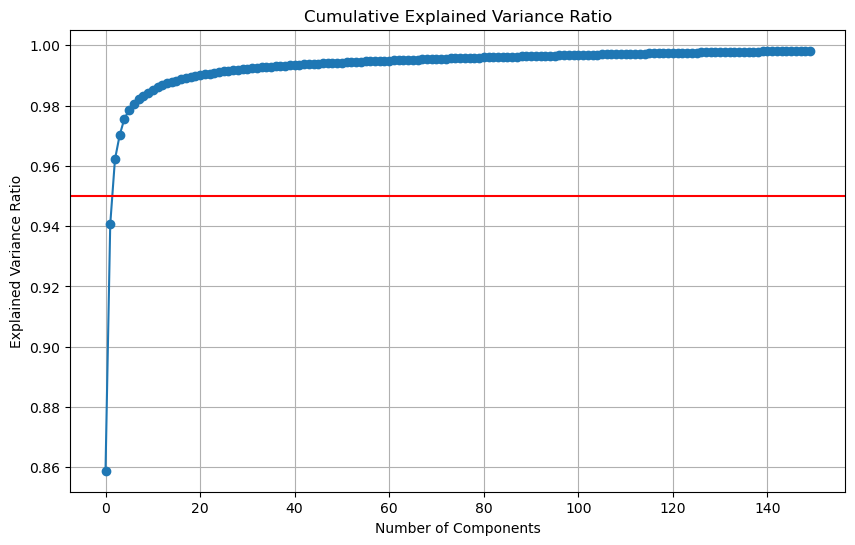

Number of components needed to explain 95% variance: 3
Top 5 principal components explain: 0.9757 of variance
Original FFT features shape: (11032, 1025)
PCA FFT features shape: (11032, 150)


In [4]:
def apply_pca_to_fft(fft_features, test_features=None, n_components=100, plot=True):
    """
    Áp dụng PCA để giảm số chiều của đặc trưng FFT.
    
    Args:
        fft_features: Mảng đặc trưng FFT cho tập huấn luyện
        test_features: Mảng đặc trưng FFT cho tập kiểm tra (nếu có)
        n_components: Số lượng thành phần chính muốn giữ lại
        plot: Vẽ đồ thị tỷ lệ phương sai giải thích được
        
    Returns:
        fft_pca: Đặc trưng FFT sau khi áp dụng PCA cho tập huấn luyện
        test_pca: Đặc trưng FFT sau khi áp dụng PCA cho tập kiểm tra (nếu có)
        pca: Đối tượng PCA đã được huấn luyện
    """
    from sklearn.decomposition import PCA
    
    # Khởi tạo và huấn luyện PCA
    pca = PCA(n_components=n_components, random_state=53940)
    fft_pca = pca.fit_transform(fft_features)
    
    # Áp dụng cho tập kiểm tra (nếu có)
    test_pca = None
    if test_features is not None:
        test_pca = pca.transform(test_features)
    
    # Vẽ đồ thị tỷ lệ phương sai giải thích được
    if plot:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_variance_ratio, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.grid(True)
        plt.title('Cumulative Explained Variance Ratio')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        plt.show()
        
        # Tìm số lượng thành phần cần thiết để giải thích 95% phương sai
        n_components_95 = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
        print(f"Number of components needed to explain 95% variance: {n_components_95}")
        
        # Hiển thị top 5 thành phần chính quan trọng nhất
        print(f"Top 5 principal components explain: {np.sum(explained_variance_ratio[:5]):.4f} of variance")
    
    return fft_pca, test_pca, pca

train_fft_pca, test_fft_pca, fft_pca = apply_pca_to_fft(
    train_fft, test_features=test_fft, n_components=150
)

print(f"Original FFT features shape: {train_fft.shape}")
print(f"PCA FFT features shape: {train_fft_pca.shape}")

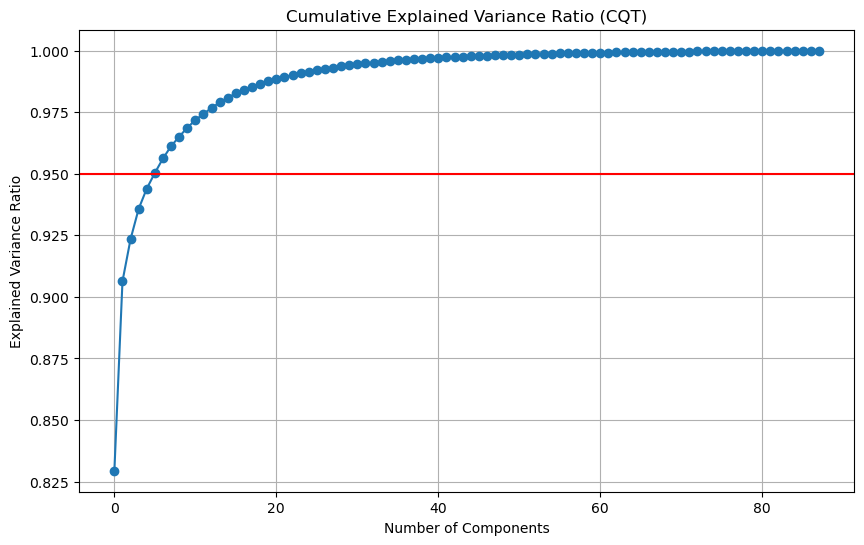

Number of components needed to explain 95% variance (CQT): 6
Top 5 principal components explain: 0.9440 of variance (CQT)
Original CQT features shape: (11032, 96)
PCA CQT features shape: (11032, 88)


In [5]:
def apply_pca_to_cqt(cqt_features, test_features=None, n_components=100, plot=True):
    """
    Áp dụng PCA để giảm số chiều của đặc trưng CQT.
    
    Args:
        cqt_features: Mảng đặc trưng CQT cho tập huấn luyện
        test_features: Mảng đặc trưng CQT cho tập kiểm tra (nếu có)
        n_components: Số lượng thành phần chính muốn giữ lại
        plot: Vẽ đồ thị tỷ lệ phương sai giải thích được
        
    Returns:
        cqt_pca: Đặc trưng CQT sau khi áp dụng PCA cho tập huấn luyện
        test_pca: Đặc trưng CQT sau khi áp dụng PCA cho tập kiểm tra (nếu có)
        pca: Đối tượng PCA đã được huấn luyện
    """
    from sklearn.decomposition import PCA
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Khởi tạo và huấn luyện PCA
    pca = PCA(n_components=n_components, random_state=53940)
    cqt_pca = pca.fit_transform(cqt_features)
    
    # Áp dụng cho tập kiểm tra (nếu có)
    test_pca = None
    if test_features is not None:
        test_pca = pca.transform(test_features)
    
    # Vẽ đồ thị tỷ lệ phương sai giải thích được
    if plot:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_variance_ratio, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.grid(True)
        plt.title('Cumulative Explained Variance Ratio (CQT)')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        plt.show()
        
        # Tìm số lượng thành phần cần thiết để giải thích 95% phương sai
        n_components_95 = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
        print(f"Number of components needed to explain 95% variance (CQT): {n_components_95}")
        
        # Hiển thị top 5 thành phần chính quan trọng nhất
        print(f"Top 5 principal components explain: {np.sum(explained_variance_ratio[:5]):.4f} of variance (CQT)")
    
    return cqt_pca, test_pca, pca

# Áp dụng PCA cho CQT features
train_cqt_pca, test_cqt_pca, cqt_pca = apply_pca_to_cqt(
    train_cqt, test_features=test_cqt, n_components=88 
)

print(f"Original CQT features shape: {train_cqt.shape}")
print(f"PCA CQT features shape: {train_cqt_pca.shape}")

In [6]:
train_features = np.hstack((train_fft_pca, train_cqt_pca))
test_features = np.hstack((test_fft_pca, test_cqt_pca))

print(f"Combined features shape: {train_features.shape}")
print(f"Test combined features shape: {test_features.shape}")

Combined features shape: (11032, 238)
Test combined features shape: (2760, 238)


In [7]:
start_time = time.time()

svm_rbf_classifier = SVC(C=71.19418600172986, kernel='rbf', degree=3, gamma=0.03752055855124281, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.0005319450186421158, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)


# Huấn luyện mô hình SVM trên dữ liệu kết hợp
svm_rbf_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features)
test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_svm * 100:.2f}%")

Training time: 12.80 seconds
Test Accuracy (SVM with RBF Kernel): 89.67%


In [8]:
stft_train_features, stft_train_labels = joblib.load('stft_features_train.pkl'), joblib.load('stft_labels_train.pkl')
stft_test_features, stft_test_labels = joblib.load('stft_features_test.pkl'), joblib.load('stft_labels_test.pkl')
stft_val_features, stft_val_labels = joblib.load('stft_features_val.pkl'), joblib.load('stft_labels_val.pkl')

stft_train_features = np.vstack((stft_train_features, stft_val_features))
stft_train_labels = np.hstack((stft_train_labels, stft_val_labels))

In [9]:
stft_train_features.shape

(11032, 1025)

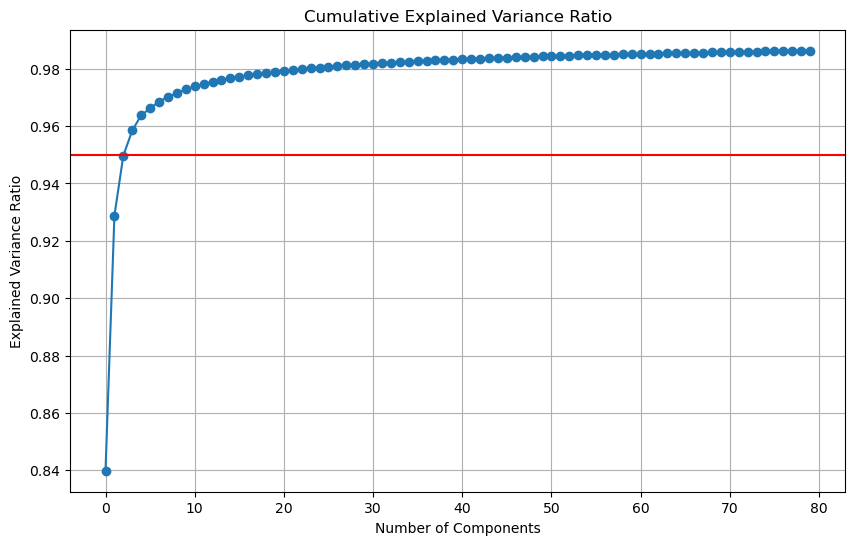

Number of components needed to explain 95% variance: 4
Top 5 principal components explain: 0.9637 of variance
Original STFT features shape: (11032, 1025)
PCA STFT features shape: (11032, 80)


In [10]:
def apply_pca_to_stft(stft_features, test_features=None, n_components=100, plot=True):
    from sklearn.decomposition import PCA
    
    # Khởi tạo và huấn luyện PCA
    pca = PCA(n_components=n_components, random_state=3951)
    fft_pca = pca.fit_transform(stft_features)
    
    # Áp dụng cho tập kiểm tra (nếu có)
    test_pca = None
    if test_features is not None:
        test_pca = pca.transform(test_features)
    
    # Vẽ đồ thị tỷ lệ phương sai giải thích được
    if plot:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_variance_ratio, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.grid(True)
        plt.title('Cumulative Explained Variance Ratio')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        plt.show()
        
        # Tìm số lượng thành phần cần thiết để giải thích 95% phương sai
        n_components_95 = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
        print(f"Number of components needed to explain 95% variance: {n_components_95}")
        
        # Hiển thị top 5 thành phần chính quan trọng nhất
        print(f"Top 5 principal components explain: {np.sum(explained_variance_ratio[:5]):.4f} of variance")
    
    return fft_pca, test_pca, pca

train_stft_pca, test_stft_pca, stft_pca = apply_pca_to_stft(
    stft_train_features, test_features=stft_test_features, n_components=80
)

print(f"Original STFT features shape: {stft_train_features.shape}")
print(f"PCA STFT features shape: {train_stft_pca.shape}")

In [11]:
combined_train_features = np.hstack((train_features, train_stft_pca))
combined_test_features = np.hstack((test_features, test_stft_pca))

In [12]:
combined_train_features.shape

(11032, 318)

In [13]:
start_time = time.time()

svm_rbf_classifier = SVC(C=50, kernel='rbf', degree=3, gamma=0.037, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.001, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)


# Huấn luyện mô hình SVM trên dữ liệu kết hợp
svm_rbf_classifier.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(combined_test_features)
test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_svm * 100:.2f}%")

Training time: 19.62 seconds
Test Accuracy (SVM with RBF Kernel): 89.82%


89.82%

In [14]:
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Huấn luyện mô hình Random Forest
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, min_samples_split=2, 
                                       min_samples_leaf=1, max_features='sqrt', bootstrap=True, n_jobs=-1, 
                                       random_state=42)

rf_classifier.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình
test_predictions_rf = rf_classifier.predict(combined_test_features)
test_accuracy_rf = accuracy_score(test_labels, test_predictions_rf)
print(f"Random Forest - Test Accuracy: {test_accuracy_rf * 100:.2f}%")

# Lấy độ quan trọng của đặc trưng
feature_importances = rf_classifier.feature_importances_

# Sắp xếp các đặc trưng theo độ quan trọng
sorted_indices = np.argsort(feature_importances)[::-1]

# Chọn số lượng đặc trưng quan trọng nhất (ví dụ: chọn top 20)
num_features = 70
selected_features_indices = sorted_indices[:num_features]

# Lọc lại dữ liệu với các đặc trưng đã chọn
rf_selected_train_features = combined_train_features[:, selected_features_indices]
rf_selected_test_features = combined_test_features[:, selected_features_indices]

# Huấn luyện lại mô hình với tập dữ liệu đã chọn lọc
rf_classifier.fit(rf_selected_train_features, train_labels)
rf_test_predictions_selected = rf_classifier.predict(rf_selected_test_features)
rf_selected_test_accuracy = accuracy_score(test_labels, rf_test_predictions_selected)
print(f"Test Accuracy with Selected Features: {rf_selected_test_accuracy * 100:.2f}%")


Training time: 3.22 seconds
Random Forest - Test Accuracy: 85.40%
Test Accuracy with Selected Features: 86.74%


100 86.41%
50 86.56%

In [15]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='log_loss', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=-1, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(combined_test_features)
scale_test_accuracy_et = accuracy_score(test_labels, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_et * 100:.2f}%")



Training time: 4.52 seconds
Test Accuracy (Extra Trees): 86.70%


n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1 86.34%
n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1 86.49%
n_estimators=200, criterion='gini', max_depth=40, min_samples_split=2, min_samples_leaf=1 86.52%
n_estimators=200, criterion='log_loss', max_depth=40, min_samples_split=2, min_samples_leaf=1 86.70%

In [16]:
start_time = time.time()

knn_classifier_cqt = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='brute', leaf_size=2, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

knn_classifier_cqt.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_knn = knn_classifier_cqt.predict(combined_test_features)

test_accuracy_cqt_knn = accuracy_score(test_labels, test_pred_cqt_knn)
print(f"KNN (combine) - Test Accuracy: {test_accuracy_cqt_knn*100:.2f}%")


Training time: 0.02 seconds
KNN (combine) - Test Accuracy: 87.97%


In [17]:
import numpy as np
import time
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Huấn luyện mô hình LightGBM
start_time = time.time()

lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=30,
    random_state=42
)
lgbm_classifier.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"\nTraining time (LightGBM): {end_time - start_time:.2f} seconds")

# Đánh giá mô hình
test_predictions_lgbm = lgbm_classifier.predict(combined_test_features)
test_accuracy_lgbm = accuracy_score(test_labels, test_predictions_lgbm)
print(f"Test Accuracy (LightGBM): {test_accuracy_lgbm * 100:.2f}%")

# Lấy độ quan trọng của đặc trưng
feature_importances = lgbm_classifier.feature_importances_

# Sắp xếp các đặc trưng theo độ quan trọng
sorted_indices = np.argsort(feature_importances)[::-1]

num_features = 20
selected_features_indices = sorted_indices[:num_features]

# Lọc lại dữ liệu với các đặc trưng đã chọn
selected_train_features = combined_train_features[:, selected_features_indices]
selected_test_features = combined_test_features[:, selected_features_indices]

# Huấn luyện lại mô hình với tập dữ liệu đã chọn lọc
lgbm_classifier.fit(selected_train_features, train_labels)
test_predictions_selected = lgbm_classifier.predict(selected_test_features)
selected_test_accuracy = accuracy_score(test_labels, test_predictions_selected)
print(f"Test Accuracy with Selected Features (LightGBM): {selected_test_accuracy * 100:.2f}%")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81090
[LightGBM] [Info] Number of data points in the train set: 11032, number of used features: 318
[LightGBM] [Info] Start training from score -0.924208
[LightGBM] [Info] Start training from score -1.383398
[LightGBM] [Info] Start training from score -1.042905

Training time (LightGBM): 4.65 seconds
Test Accuracy (LightGBM): 85.72%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 11032, number of used features: 20
[LightGBM] [Info] Start training from score -0.924208
[LightGBM] [Info] Start training from score -1.383398
[LightGBM] [Info] Start training from score -1.042905


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy with Selected Features (LightGBM): 86.01%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [18]:
import numpy as np

# Lấy dự đoán từ tất cả các mô hình
test_pred_svm = svm_rbf_classifier.predict(combined_test_features)
test_pred_knn = knn_classifier_cqt.predict(combined_test_features)
test_pred_et = et_classifier.predict(combined_test_features)
test_pred_rf = rf_classifier.predict(rf_selected_test_features)
test_pred_lightgbm = lgbm_classifier.predict(selected_test_features)

# Tạo hàm voting có trọng số
def weighted_vote(svm_pred, knn_pred, et_pred, rf_pred, lightgbm_pred, classes, svm_weight=0.4, knn_weight=0.3, et_weight=0.3, rf_weight=0.0, lightgbm_weight=0.0):
    predictions = []
    
    for i in range(len(svm_pred)):
        # Tạo một từ điển để lưu trữ điểm số cho mỗi lớp
        class_scores = {cls: 0 for cls in classes}
        
        # Thêm điểm theo trọng số cho mỗi dự đoán
        class_scores[svm_pred[i]] += svm_weight
        class_scores[knn_pred[i]] += knn_weight
        class_scores[et_pred[i]] += et_weight
        class_scores[rf_pred[i]] += rf_weight
        class_scores[lightgbm_pred[i]] += lightgbm_weight
        
        # Chọn lớp có điểm cao nhất
        best_class = max(class_scores, key=class_scores.get)
        predictions.append(best_class)
    
    return np.array(predictions)

# Lấy danh sách các lớp duy nhất
unique_classes = np.unique(train_labels)

# Thực hiện voting
weighted_predictions = weighted_vote(test_pred_svm, test_pred_knn, test_pred_et, test_pred_rf, test_pred_lightgbm,
                                    unique_classes, svm_weight=0.4, knn_weight=0.3, et_weight=0.1, rf_weight=0.1, lightgbm_weight=0.1)

# Đánh giá kết quả
ensemble_accuracy = accuracy_score(test_labels, weighted_predictions)
print(f"Ensemble Model Accuracy (Weighted Voting): {ensemble_accuracy * 100:.2f}%")

# So sánh với các mô hình riêng lẻ
print(f"SVM Accuracy: {test_accuracy_svm * 100:.2f}%")
print(f"KNN Accuracy: {test_accuracy_cqt_knn * 100:.2f}%")
print(f"Extra Trees Accuracy: {scale_test_accuracy_et * 100:.2f}%")
print(f"Random Forest Accuracy: {selected_test_accuracy * 100:.2f}%")
print(f"LightGBM Accuracy: {test_accuracy_lgbm * 100:.2f}%")

Ensemble Model Accuracy (Weighted Voting): 90.11%
SVM Accuracy: 89.82%
KNN Accuracy: 87.97%
Extra Trees Accuracy: 86.70%
Random Forest Accuracy: 86.01%
LightGBM Accuracy: 85.72%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [80]:
from itertools import product
from sklearn.metrics import accuracy_score
import numpy as np

# Tạo danh sách các trọng số có thể có, với bước nhảy nhỏ để tìm tối ưu
weight_range = np.arange(0, 0.6, 0.1)

best_weights = None
best_accuracy = 0

# Duyệt qua tất cả các tổ hợp trọng số có tổng bằng 1
for svm_weight, knn_weight, et_weight, rf_weight, lightgbm_weight in product(weight_range, repeat=5):
    if np.isclose(svm_weight + knn_weight + et_weight + rf_weight + lightgbm_weight, 1.0):  # Tổng trọng số phải bằng 1
        weighted_predictions = weighted_vote(
            test_pred_svm, test_pred_knn, test_pred_et, test_pred_rf, test_pred_lightgbm, unique_classes, 
            svm_weight=svm_weight, knn_weight=knn_weight, et_weight=et_weight, rf_weight=rf_weight, lightgbm_weight=lightgbm_weight
        )
        acc = accuracy_score(test_labels, weighted_predictions)

        # In kết quả từng bước
        print(f"Weights -> SVM: {svm_weight:.2f}, KNN: {knn_weight:.2f}, ET: {et_weight:.2f}, RF: {rf_weight:.2f}, LightGBM: {lightgbm_weight:.2f} | Accuracy: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_weights = (svm_weight, knn_weight, et_weight, rf_weight, lightgbm_weight)

print(f"\nBest Weights -> SVM: {best_weights[0]:.2f}, KNN: {best_weights[1]:.2f}, ET: {best_weights[2]:.2f}, RF: {best_weights[3]:.2f}, LightGBM: {best_weights[4]:.2f}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")


Weights -> SVM: 0.00, KNN: 0.00, ET: 0.00, RF: 0.50, LightGBM: 0.50 | Accuracy: 0.8623
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.10, RF: 0.40, LightGBM: 0.50 | Accuracy: 0.8627
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.10, RF: 0.50, LightGBM: 0.40 | Accuracy: 0.8674
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.20, RF: 0.30, LightGBM: 0.50 | Accuracy: 0.8627
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.20, RF: 0.40, LightGBM: 0.40 | Accuracy: 0.8678
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.20, RF: 0.50, LightGBM: 0.30 | Accuracy: 0.8674
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.30, RF: 0.20, LightGBM: 0.50 | Accuracy: 0.8627
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.30, RF: 0.30, LightGBM: 0.40 | Accuracy: 0.8678
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.30, RF: 0.40, LightGBM: 0.30 | Accuracy: 0.8678
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.30, RF: 0.50, LightGBM: 0.20 | Accuracy: 0.8674
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.40, RF: 0.10, LightGBM: 0.50 | Accuracy: 0.8627
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.40, 

In [19]:
from sklearn.metrics import f1_score

# Tính F1-score cho từng mô hình
f1_svm = f1_score(test_labels, test_pred_svm, average='weighted')
f1_knn = f1_score(test_labels, test_pred_knn, average='weighted')
f1_et = f1_score(test_labels, test_pred_et, average='weighted')
f1_rf = f1_score(test_labels, test_pred_rf, average='weighted')
f1_lgbm = f1_score(test_labels, test_pred_lightgbm, average='weighted')

# Tính F1-score cho mô hình ensemble
f1_ensemble = f1_score(test_labels, weighted_predictions, average='weighted')

# In kết quả
print(f"SVM F1-score: {f1_svm:.4f}")
print(f"KNN F1-score: {f1_knn:.4f}")
print(f"Extra Trees F1-score: {f1_et:.4f}")
print(f"Random Forest F1-score: {f1_rf:.4f}")
print(f"LightGBM F1-score: {f1_lgbm:.4f}")
print(f"Ensemble Model F1-score: {f1_ensemble:.4f}")


SVM F1-score: 0.8962
KNN F1-score: 0.8744
Extra Trees F1-score: 0.8556
Random Forest F1-score: 0.8576
LightGBM F1-score: 0.8528
Ensemble Model F1-score: 0.8971


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Model Performance Comparison ---
                  Model Accuracy (%) F1 Score (Weighted)
   Weighted Hard Voting        90.11               89.71
                    SVM        89.82               89.62
            Hard Voting        88.19               87.42
Distance-Based Stacking        88.19               87.44
               Stacking        88.15               87.40
                    KNN        87.97               87.44
          Random Forest        86.74               85.76
            Extra Trees        86.70               85.56
               LightGBM        86.01               85.28


<Figure size 1400x800 with 0 Axes>

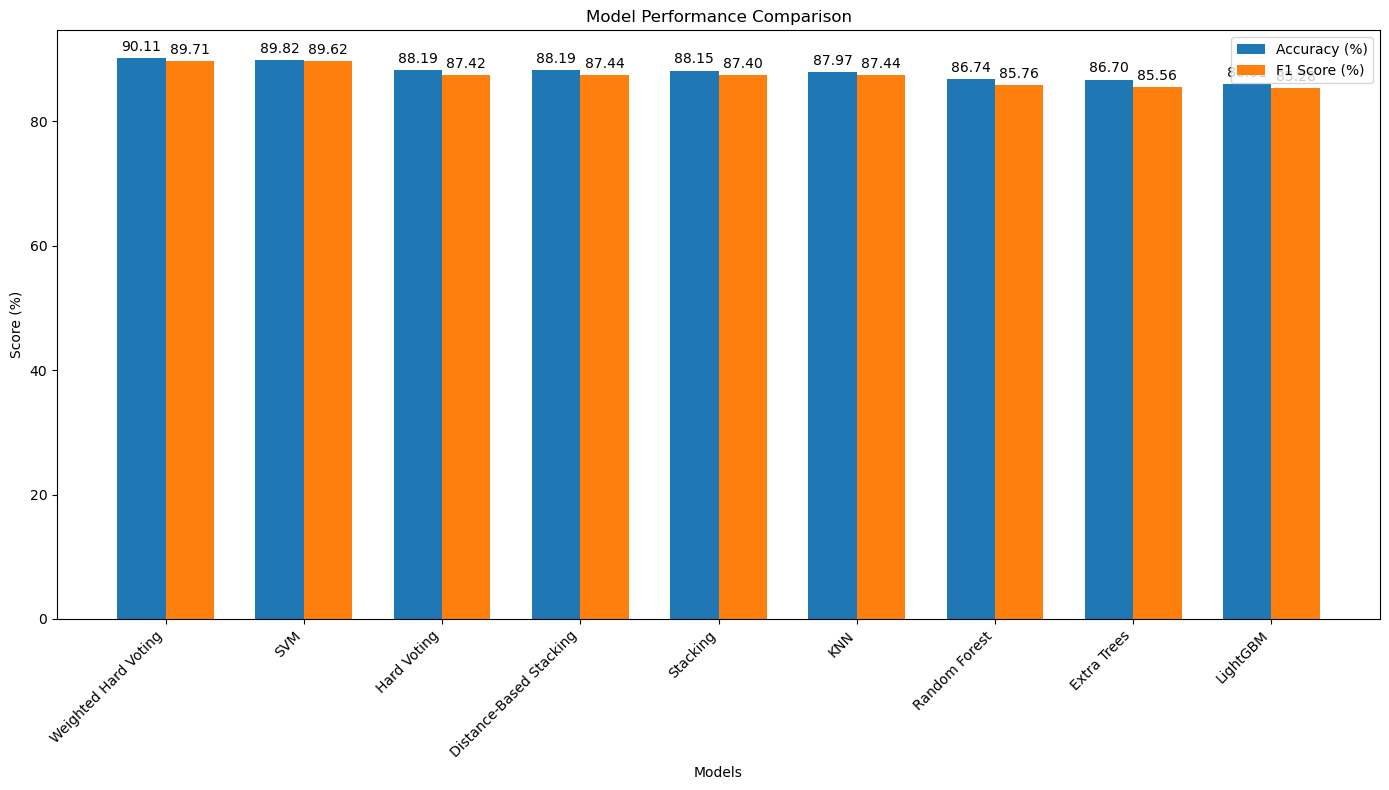

In [41]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ---- Hard Voting (without weights) ----
def hard_voting(predictions_list):
    """
    Simple majority voting without weights
    """
    predictions = []
    for i in range(len(predictions_list[0])):
        # Get votes for this sample from all classifiers
        votes = [model_preds[i] for model_preds in predictions_list]
        
        # Count occurrences of each class
        vote_counts = {}
        for vote in votes:
            vote_counts[vote] = vote_counts.get(vote, 0) + 1
        
        # Find class with most votes
        most_common = max(vote_counts.items(), key=lambda x: x[1])[0]
        predictions.append(most_common)
    
    return np.array(predictions)

# ---- Weighted Hard Voting (your existing implementation) ----
# You already have this implemented correctly

# ---- Stacking (without predict_proba) ----
def train_stacking_model():
    """
    Train a stacking ensemble using the base models' predictions as features
    """
    # Get base model predictions on training data
    train_pred_svm = svm_rbf_classifier.predict(combined_train_features)
    train_pred_knn = knn_classifier_cqt.predict(combined_train_features)
    train_pred_et = et_classifier.predict(combined_train_features)
    train_pred_rf = rf_classifier.predict(rf_selected_train_features)
    train_pred_lightgbm = lgbm_classifier.predict(selected_train_features)
    
    # Encode categorical predictions to numerical values for meta-features
    le = LabelEncoder()
    le.fit(train_labels)
    
    # Transform predictions to numerical values
    train_pred_svm_encoded = le.transform(train_pred_svm)
    train_pred_knn_encoded = le.transform(train_pred_knn)
    train_pred_et_encoded = le.transform(train_pred_et)
    train_pred_rf_encoded = le.transform(train_pred_rf)
    train_pred_lightgbm_encoded = le.transform(train_pred_lightgbm)
    
    # Create meta-features from encoded predictions
    meta_features_train = np.column_stack([
        train_pred_svm_encoded,
        train_pred_knn_encoded,
        train_pred_et_encoded,
        train_pred_rf_encoded,
        train_pred_lightgbm_encoded
    ])
    
    # Train meta-learner
    meta_learner = LogisticRegression(max_iter=1000)
    meta_learner.fit(meta_features_train, train_labels)
    
    # Encode test predictions for meta-features
    test_pred_svm_encoded = le.transform(test_pred_svm)
    test_pred_knn_encoded = le.transform(test_pred_knn)
    test_pred_et_encoded = le.transform(test_pred_et)
    test_pred_rf_encoded = le.transform(test_pred_rf)
    test_pred_lightgbm_encoded = le.transform(test_pred_lightgbm)
    
    # Create meta-features for test set
    meta_features_test = np.column_stack([
        test_pred_svm_encoded,
        test_pred_knn_encoded,
        test_pred_et_encoded,
        test_pred_rf_encoded,
        test_pred_lightgbm_encoded
    ])
    
    # Make predictions with meta-learner
    stacking_predictions = meta_learner.predict(meta_features_test)
    
    return stacking_predictions

# ---- Alternative Stacking (Distance-Based Method) ----
def train_distance_stacking_model():
    """
    A stacking approach that uses confidence measures derived from KNN distances
    instead of probabilities
    """
    # Define a function to extract a "confidence" measure without predict_proba
    def get_confidence_feature(model, features):
        if hasattr(model, 'kneighbors'):  # For KNN
            # Get distances to k nearest neighbors
            distances, _ = model.kneighbors(features)
            # Use inverse of mean distance as a confidence measure
            return 1.0 / (distances.mean(axis=1) + 0.0001)
        else:
            # For other models, we'll use a dummy confidence of 1
            predictions = model.predict(features)
            return np.ones(len(predictions))
    
    # Get model predictions on training data
    train_pred_svm = svm_rbf_classifier.predict(combined_train_features)
    train_pred_knn = knn_classifier_cqt.predict(combined_train_features)
    train_pred_et = et_classifier.predict(combined_train_features)
    train_pred_rf = rf_classifier.predict(rf_selected_train_features)
    train_pred_lightgbm = lgbm_classifier.predict(selected_train_features)
    
    # Add confidence-like features where possible
    knn_conf_train = get_confidence_feature(knn_classifier_cqt, combined_train_features)
    
    # Encode categorical predictions
    le = LabelEncoder()
    le.fit(np.concatenate([train_labels, test_labels]))
    
    train_pred_svm_encoded = le.transform(train_pred_svm)
    train_pred_knn_encoded = le.transform(train_pred_knn)
    train_pred_et_encoded = le.transform(train_pred_et)
    train_pred_rf_encoded = le.transform(train_pred_rf)
    train_pred_lightgbm_encoded = le.transform(train_pred_lightgbm)
    
    # Create meta-features
    meta_features_train = np.column_stack([
        train_pred_svm_encoded,
        train_pred_knn_encoded,
        train_pred_et_encoded,
        train_pred_rf_encoded,
        train_pred_lightgbm_encoded,
        knn_conf_train  # Add confidence feature
    ])
    
    # Train meta-learner
    meta_learner = LogisticRegression(max_iter=1000)
    meta_learner.fit(meta_features_train, train_labels)
    
    # Create test meta-features
    test_pred_svm_encoded = le.transform(test_pred_svm)
    test_pred_knn_encoded = le.transform(test_pred_knn)
    test_pred_et_encoded = le.transform(test_pred_et)
    test_pred_rf_encoded = le.transform(test_pred_rf)
    test_pred_lightgbm_encoded = le.transform(test_pred_lightgbm)
    
    # Get confidence for test data
    knn_conf_test = get_confidence_feature(knn_classifier_cqt, combined_test_features)
    
    meta_features_test = np.column_stack([
        test_pred_svm_encoded,
        test_pred_knn_encoded,
        test_pred_et_encoded,
        test_pred_rf_encoded,
        test_pred_lightgbm_encoded,
        knn_conf_test
    ])
    
    # Predict with meta-learner
    distance_stacking_predictions = meta_learner.predict(meta_features_test)
    
    return distance_stacking_predictions

# ---- Apply Ensemble Methods ----
# List of all model predictions
all_predictions = [test_pred_svm, test_pred_knn, test_pred_et, test_pred_rf, test_pred_lightgbm]

# Execute ensemble methods
hard_vote_predictions = hard_voting(all_predictions)
stacking_predictions = train_stacking_model()
distance_stacking_predictions = train_distance_stacking_model()

# Calculate metrics for each model
# Accuracy
svm_accuracy = accuracy_score(test_labels, test_pred_svm)
knn_accuracy = accuracy_score(test_labels, test_pred_knn)
et_accuracy = accuracy_score(test_labels, test_pred_et)
rf_accuracy = accuracy_score(test_labels, test_pred_rf)
lgbm_accuracy = accuracy_score(test_labels, test_pred_lightgbm)

hard_vote_accuracy = accuracy_score(test_labels, hard_vote_predictions)
weighted_hard_accuracy = accuracy_score(test_labels, weighted_predictions)
stacking_accuracy = accuracy_score(test_labels, stacking_predictions)
distance_stacking_accuracy = accuracy_score(test_labels, distance_stacking_predictions)

# F1 scores
svm_f1 = f1_score(test_labels, test_pred_svm, average='weighted')
knn_f1 = f1_score(test_labels, test_pred_knn, average='weighted')
et_f1 = f1_score(test_labels, test_pred_et, average='weighted')
rf_f1 = f1_score(test_labels, test_pred_rf, average='weighted')
lgbm_f1 = f1_score(test_labels, test_pred_lightgbm, average='weighted')

hard_vote_f1 = f1_score(test_labels, hard_vote_predictions, average='weighted')
weighted_hard_f1 = f1_score(test_labels, weighted_predictions, average='weighted')
stacking_f1 = f1_score(test_labels, stacking_predictions, average='weighted')
distance_stacking_f1 = f1_score(test_labels, distance_stacking_predictions, average='weighted')

# Create comparison table with all models
results = {
    'Model': [
        'SVM', 
        'KNN', 
        'Extra Trees', 
        'Random Forest', 
        'LightGBM',
        'Hard Voting',
        'Weighted Hard Voting',
        'Stacking',
        'Distance-Based Stacking'
    ],
    'Accuracy (%)': [
        svm_accuracy * 100,
        knn_accuracy * 100,
        et_accuracy * 100,
        rf_accuracy * 100,
        lgbm_accuracy * 100,
        hard_vote_accuracy * 100,
        weighted_hard_accuracy * 100,
        stacking_accuracy * 100,
        distance_stacking_accuracy * 100
    ],
    'F1 Score (Weighted)': [
        svm_f1 * 100,
        knn_f1 * 100,
        et_f1 * 100,
        rf_f1 * 100,
        lgbm_f1 * 100,
        hard_vote_f1 * 100,
        weighted_hard_f1 * 100,
        stacking_f1 * 100,
        distance_stacking_f1 * 100
    ]
}

# Create and display comparison table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy (%)', ascending=False)

# Format the float values to 2 decimal places
results_df['Accuracy (%)'] = results_df['Accuracy (%)'].map('{:.2f}'.format)
results_df['F1 Score (Weighted)'] = results_df['F1 Score (Weighted)'].map('{:.2f}'.format)

print("\n--- Model Performance Comparison ---")
print(results_df.to_string(index=False))

# Create a bar chart comparing the models
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

models = results_df['Model']
acc = results_df['Accuracy (%)'].astype(float)
f1 = results_df['F1 Score (Weighted)'].astype(float)

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, acc, width, label='Accuracy (%)')
rects2 = ax.bar(x + width/2, f1, width, label='F1 Score (%)')

ax.set_xlabel('Models')
ax.set_ylabel('Score (%)')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

fig.tight_layout()
plt.savefig('model_comparison.png')
plt.show()